In [1]:
import numpy as np
import geopandas as gpd

# Read the GeoJSON file
catastici = gpd.read_file("../data/raw/20240221_Catastici1741_Intermediate.geojson")

# Filtering the dataset

In [2]:
# filter the necessary datapoints
catastici_ppl = catastici[(catastici['owner_code'] == 'PPL') & (catastici['owner_count']=='1')]
catastici_ppl = catastici_ppl[['owner_first_name','owner_family_name','function','place','an_rendi']]

In [3]:
# format the NaN values
catastici_ppl.loc[catastici_ppl.owner_first_name=='', 'owner_first_name'] = np.nan
catastici_ppl.loc[catastici_ppl['function']=='nan', 'function'] = np.nan
catastici_ppl.loc[catastici_ppl['place']=='nan', 'place'] = np.nan
catastici_ppl['an_rendi'] = [val + ' ducati' if val.isnumeric() else val for val in catastici_ppl['an_rendi']]
catastici_ppl.loc[catastici_ppl['an_rendi']=='nan', 'an_rendi'] = '0'

In [5]:
# rename the columns
catastici_ppl.rename({
    'owner_first_name':'Owner_First_Name',
    'owner_family_name':'Owner_Family_Name',
    'function':'Property_Type',
    'place':'Property_Location',
    'an_rendi':'Rent_Income'
}, axis=1, inplace=True)
catastici_ppl.to_csv(f'../data/clean/catastici.csv', index=False)

# Creating QA pairs - train

In [19]:
def create_questions(data):
    questions = [
        f"What is the family name of {data['Owner_First_Name']} who owns {data['Property_Type']} in {data['Property_Location']}?",
        f"How much does {data['Owner_First_Name']} {data['Owner_Family_Name']} earn from their property {data['Property_Type']} in {data['Property_Location']}?",
        f"What type of property does {data['Owner_First_Name']} {data['Owner_Family_Name']} own in {data['Property_Location']}?",
        f"Where is the property {data['Property_Type']} of {data['Owner_First_Name']} {data['Owner_Family_Name']} located?",
        f"Who owns a property {data['Property_Type']} in {data['Property_Location']} with the family name of {data['Owner_Family_Name']}?"
    ]
    return questions

def create_answers(data):
    answers = [
        data['Owner_Family_Name'],
        data['Rent_Income'],
        data['Property_Type'],
        data['Property_Location'],
        data['Owner_First_Name']
    ]
    return answers

# copy the filtered dataset
data_raw = catastici_ppl.copy()

# create QA pairs
data_raw['question'] = data_raw.apply(lambda row: create_questions(row), axis=1)
data_raw['answer'] = data_raw.apply(lambda row: create_answers(row), axis=1)
data = data_raw.explode(['question', 'answer']).reset_index(drop=True)

# save the data
data[['question','answer']].to_csv(f'../data/train/train_qa.csv', index=False)

# Test pairs

In [20]:
import pandas as pd
data = pd.read_csv('../data/train/train_qa.csv')

In [21]:
# get the length of answer
data['answer'] = data['answer'].fillna('')
data['answer_len'] = data.apply(lambda row: len(row['answer'].split()), axis=1)
data['char_len'] = data.apply(lambda row: len(row['answer']), axis=1)

<AxesSubplot:>

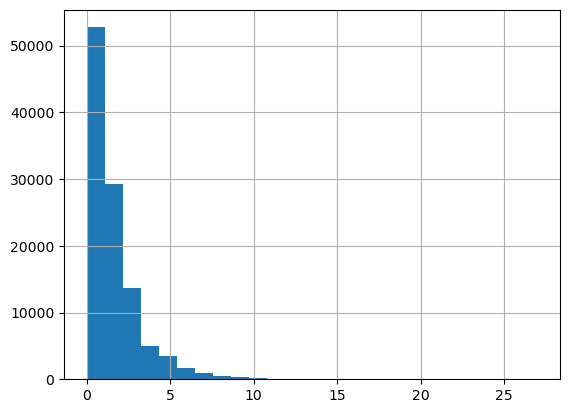

In [22]:
data['answer_len'].hist(bins=25)

<AxesSubplot:>

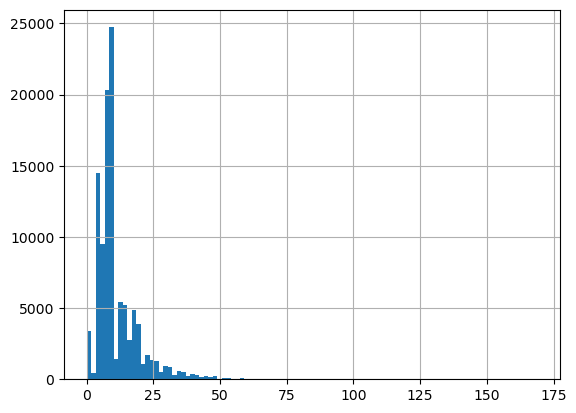

In [23]:
data['char_len'].hist(bins=100)

In [24]:
seed = 42
np.random.seed(seed)
data = data[:100000]
data_sample = data[(data['answer_len'] < 4) & (data['char_len'] < 20)].sample(1000)
data_sample = data_sample[['question','answer']].reset_index(drop=True)
data_sample.to_csv(f'../data/train/test_qa.csv', index=False)